In [90]:
import pandas as pd
import numpy as np
import math
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Initialize Variables

In [2]:
df_list = ['dfmajorcrimes', 'dfhomicidies']

# Data Loading

In [3]:
def show_all_columns(df):
    with pd.option_context('display.max_columns', None):
        display(df)
def show_all_rows(df):
    with pd.option_context('display.max_rows', None):
        display(df)

In [4]:
dfmajorcrimes = pd.read_csv('raw_data/majorcrimes.csv')
dfhomicides = pd.read_csv('raw_data/homicidies.csv')


In [5]:
# Define the target columns including the ones that need to be added
columns = ['EVENT_UNIQUE_ID','DATASET','OFFENCE', 'MCI_CATEGORY','OCC_HOUR','OCC_DAY','OCC_MONTH','OCC_YEAR','OCC_DOW','OCC_DOY','LAT_WGS84','LONG_WGS84']

# Add missing columns with default values
for df in [dfhomicides, dfmajorcrimes]:
    for column in columns:
        if column not in df.columns:
            df[column] = None

# Select columns in the specified order for all DataFrames
dfhomicides_s = dfhomicides[columns]
dfmajorcrimes_s = dfmajorcrimes[columns]

# Set the 'DATASET' column for each DataFrame using .loc to avoid SettingWithCopyWarning
dfhomicides_s.loc[:, 'DATASET'] = 'HOMICIDES'
dfmajorcrimes_s.loc[:, 'DATASET'] = 'MAJOR_CRIMES'

# Concatenate the DataFrames into a single DataFrame
dfmatrix = pd.concat([dfhomicides_s, dfmajorcrimes_s], ignore_index=True)

# Display the resulting DataFrame
dfmatrix

,EVENT_UNIQUE_ID,DATASET,OFFENCE,MCI_CATEGORY,OCC_HOUR,OCC_DAY,OCC_MONTH,OCC_YEAR,OCC_DOW,OCC_DOY,LAT_WGS84,LONG_WGS84
0,GO-2004111878,HOMICIDES,None,None,None,3.0,January,2004.0,Saturday,3.0,43.685026,-79.392828
1,GO-2004125755,HOMICIDES,None,None,None,8.0,January,2004.0,Thursday,8.0,43.781782,-79.233852
2,GO-2004136086,HOMICIDES,None,None,None,8.0,January,2004.0,Thursday,8.0,43.810544,-79.205574
3,GO-2004148623,HOMICIDES,None,None,None,25.0,January,2004.0,Sunday,25.0,43.670467,-79.434387
4,GO-2004148619,HOMICIDES,None,None,None,25.0,January,2004.0,Sunday,25.0,43.822997,-79.204958
...,...,...,...,...,...,...,...,...,...,...,...,...
386096,GO-2024688981,MAJOR_CRIMES,Theft Of Motor Vehicle,Auto Theft,16,30.0,March,2024.0,Saturday,90.0,43.755641,-79.196001
386097,GO-2024690900,MAJOR_CRIMES,Assault,Assault,16,31.0,March,2024.0,Sunday,91.0,43.595354,-79.529766
386098,GO-2024690985,MAJOR_CRIMES,Assault,Assault,16,31.0,March,2024.0,Sunday,91.0,43.688644,-79.391479
386099,GO-2024690995,MAJOR_CRIMES,Theft Of Motor Vehicle,Auto Theft,23,30.0,March,2024.0,Saturday,90.0,43.684335,-79.372581


In [6]:
dfmatrix.loc[dfmatrix['DATASET'] == 'HOMICIDES', 'OFFENCE'] = 'Homicide'
dfmatrix.loc[dfmatrix['DATASET'] == 'HOMICIDES', 'MCI_CATEGORY'] = 'Homicide'
dfmatrix

,EVENT_UNIQUE_ID,DATASET,OFFENCE,MCI_CATEGORY,OCC_HOUR,OCC_DAY,OCC_MONTH,OCC_YEAR,OCC_DOW,OCC_DOY,LAT_WGS84,LONG_WGS84
0,GO-2004111878,HOMICIDES,Homicide,Homicide,None,3.0,January,2004.0,Saturday,3.0,43.685026,-79.392828
1,GO-2004125755,HOMICIDES,Homicide,Homicide,None,8.0,January,2004.0,Thursday,8.0,43.781782,-79.233852
2,GO-2004136086,HOMICIDES,Homicide,Homicide,None,8.0,January,2004.0,Thursday,8.0,43.810544,-79.205574
3,GO-2004148623,HOMICIDES,Homicide,Homicide,None,25.0,January,2004.0,Sunday,25.0,43.670467,-79.434387
4,GO-2004148619,HOMICIDES,Homicide,Homicide,None,25.0,January,2004.0,Sunday,25.0,43.822997,-79.204958
...,...,...,...,...,...,...,...,...,...,...,...,...
386096,GO-2024688981,MAJOR_CRIMES,Theft Of Motor Vehicle,Auto Theft,16,30.0,March,2024.0,Saturday,90.0,43.755641,-79.196001
386097,GO-2024690900,MAJOR_CRIMES,Assault,Assault,16,31.0,March,2024.0,Sunday,91.0,43.595354,-79.529766
386098,GO-2024690985,MAJOR_CRIMES,Assault,Assault,16,31.0,March,2024.0,Sunday,91.0,43.688644,-79.391479
386099,GO-2024690995,MAJOR_CRIMES,Theft Of Motor Vehicle,Auto Theft,23,30.0,March,2024.0,Saturday,90.0,43.684335,-79.372581


# Data Cleaning and Transformation

In [7]:
# checking for latitude and longitude errors

# Toronto boundaries
north_boundary = 43.8554
south_boundary = 43.5810
east_boundary = -79.1161
west_boundary = -79.6393


# Check if latitude and longitude are within the boundaries
within_boundaries = (dfmatrix['LAT_WGS84'] <= north_boundary) & (dfmatrix['LAT_WGS84'] >= south_boundary) & \
                    (dfmatrix['LONG_WGS84'] >= west_boundary) & (dfmatrix['LONG_WGS84'] <= east_boundary)

# Filter the DataFrame
dfmatrix = dfmatrix.loc[within_boundaries].reset_index(drop=True)
dfmatrix

,EVENT_UNIQUE_ID,DATASET,OFFENCE,MCI_CATEGORY,OCC_HOUR,OCC_DAY,OCC_MONTH,OCC_YEAR,OCC_DOW,OCC_DOY,LAT_WGS84,LONG_WGS84
0,GO-2004111878,HOMICIDES,Homicide,Homicide,None,3.0,January,2004.0,Saturday,3.0,43.685026,-79.392828
1,GO-2004125755,HOMICIDES,Homicide,Homicide,None,8.0,January,2004.0,Thursday,8.0,43.781782,-79.233852
2,GO-2004136086,HOMICIDES,Homicide,Homicide,None,8.0,January,2004.0,Thursday,8.0,43.810544,-79.205574
3,GO-2004148623,HOMICIDES,Homicide,Homicide,None,25.0,January,2004.0,Sunday,25.0,43.670467,-79.434387
4,GO-2004148619,HOMICIDES,Homicide,Homicide,None,25.0,January,2004.0,Sunday,25.0,43.822997,-79.204958
...,...,...,...,...,...,...,...,...,...,...,...,...
380240,GO-2024688981,MAJOR_CRIMES,Theft Of Motor Vehicle,Auto Theft,16,30.0,March,2024.0,Saturday,90.0,43.755641,-79.196001
380241,GO-2024690900,MAJOR_CRIMES,Assault,Assault,16,31.0,March,2024.0,Sunday,91.0,43.595354,-79.529766
380242,GO-2024690985,MAJOR_CRIMES,Assault,Assault,16,31.0,March,2024.0,Sunday,91.0,43.688644,-79.391479
380243,GO-2024690995,MAJOR_CRIMES,Theft Of Motor Vehicle,Auto Theft,23,30.0,March,2024.0,Saturday,90.0,43.684335,-79.372581


In [8]:
# Display NA values

# Boolean mask where OCC_HOUR is NA
na_mask = dfmatrix['OCC_HOUR'].isna()

# Mask to filter the DataFrame
na_rows = dfmatrix[na_mask]

# Display the rows with NA values in OCC_HOUR column
na_rows

,EVENT_UNIQUE_ID,DATASET,OFFENCE,MCI_CATEGORY,OCC_HOUR,OCC_DAY,OCC_MONTH,OCC_YEAR,OCC_DOW,OCC_DOY,LAT_WGS84,LONG_WGS84
0,GO-2004111878,HOMICIDES,Homicide,Homicide,None,3.0,January,2004.0,Saturday,3.0,43.685026,-79.392828
1,GO-2004125755,HOMICIDES,Homicide,Homicide,None,8.0,January,2004.0,Thursday,8.0,43.781782,-79.233852
2,GO-2004136086,HOMICIDES,Homicide,Homicide,None,8.0,January,2004.0,Thursday,8.0,43.810544,-79.205574
3,GO-2004148623,HOMICIDES,Homicide,Homicide,None,25.0,January,2004.0,Sunday,25.0,43.670467,-79.434387
4,GO-2004148619,HOMICIDES,Homicide,Homicide,None,25.0,January,2004.0,Sunday,25.0,43.822997,-79.204958
...,...,...,...,...,...,...,...,...,...,...,...,...
1409,GO-2024545700,HOMICIDES,Homicide,Homicide,None,12.0,March,2024.0,Tuesday,72.0,43.659103,-79.364238
1410,GO-2024545700,HOMICIDES,Homicide,Homicide,None,12.0,March,2024.0,Tuesday,72.0,43.659103,-79.364238
1411,GO-2024558575,HOMICIDES,Homicide,Homicide,None,14.0,March,2024.0,Thursday,74.0,43.745156,-79.208993
1412,GO-2024671809,HOMICIDES,Homicide,Homicide,None,28.0,March,2024.0,Thursday,88.0,43.768847,-79.466916


### OCC_HOUR Column

In [9]:
df_hour = dfmatrix[dfmatrix['DATASET']== 'MAJOR_CRIMES'].OCC_HOUR.value_counts()/len(dfmatrix[dfmatrix['DATASET']== 'MAJOR_CRIMES'])
df_hour

OCC_HOUR
0     0.069181
21    0.054481
12    0.054288
20    0.054272
18    0.054214
22    0.053892
23    0.052298
19    0.052179
17    0.050117
15    0.048177
16    0.046306
14    0.041018
1     0.040786
2     0.040556
13    0.038138
11    0.035145
3     0.033749
10    0.033440
9     0.032930
8     0.028205
4     0.027144
5     0.020833
7     0.020669
6     0.017982
Name: count, dtype: float64

In [12]:
df_hour.dtypes

OCC_HOUR      int64
count       float64
dtype: object

In [11]:
df_hour = df_hour.to_frame().reset_index(drop=False)

df_hour

,OCC_HOUR,count
0,0,0.069181
1,21,0.054481
2,12,0.054288
3,20,0.054272
4,18,0.054214
5,22,0.053892
6,23,0.052298
7,19,0.052179
8,17,0.050117
9,15,0.048177


In [13]:
import math

for i, hour_row in df_hour.iterrows():
    size = len(dfmatrix[dfmatrix['DATASET']=='HOMICIDES'])
    for index, row in dfmatrix[((dfmatrix['DATASET']=='HOMICIDES') & (pd.isnull(dfmatrix.OCC_HOUR)))].head(math.trunc(size*hour_row['count'])).iterrows():
        dfmatrix.loc[index, 'OCC_HOUR'] = hour_row['OCC_HOUR']

In [ ]:
len(dfmatrix[pd.isnull(dfmatrix['OCC_HOUR'])])

In [14]:
# Again for the 14 remainders still showing as Nan

for i, hour_row in df_hour.iterrows():
    size = len(dfmatrix[dfmatrix['DATASET']=='HOMICIDES'])
    for index, row in dfmatrix[((dfmatrix['DATASET']=='HOMICIDES') & (pd.isnull(dfmatrix.OCC_HOUR)))].head(math.trunc(size*hour_row['count'])).iterrows():
        dfmatrix.loc[index, 'OCC_HOUR'] = hour_row['OCC_HOUR']

In [15]:
len(dfmatrix[pd.isnull(dfmatrix['OCC_HOUR'])])

0

In [16]:
dfmatrix['OCC_HOUR'] = pd.to_numeric(dfmatrix['OCC_HOUR'], errors='coerce').fillna(0).astype(int)

In [17]:
# Apply np.floor and convert to int, while handling NaN values
dfmatrix['OCC_HOUR'] = dfmatrix['OCC_HOUR'].apply(lambda x: np.floor(x) if pd.notnull(x) else x).astype('Int64')

### Fixing OCC_DAY

In [18]:
#  Converting OCC_DAY from float to int
dfmatrix['OCC_DAY'] = pd.to_numeric(dfmatrix['OCC_DAY'], errors='coerce').fillna(0).astype(int)

In [19]:
# Apply np.floor and convert to int, while handling NaN values
dfmatrix['OCC_DAY'] = dfmatrix['OCC_DAY'].apply(lambda x: np.floor(x) if pd.notnull(x) else x).astype('Int64')

In [20]:
# Filter the DataFrame for non-zero OCC_DAY values
df_occ_day_non_zero = dfmatrix[dfmatrix['OCC_DAY'] != 0]

# Calculate the value counts and normalize them
occ_day_proportions = df_occ_day_non_zero['OCC_DAY'].value_counts(normalize=True).reset_index()
occ_day_proportions.columns = ['OCC_DAY', 'proportion']

# Total number of rows where OCC_DAY is 0
total_zeros = (dfmatrix['OCC_DAY'] == 0).sum()

# Track the index of the current proportion
current_proportion_index = 0

# Iterate over the rows where OCC_DAY is 0 and update OCC_DAY based on proportions
for index, row in dfmatrix[dfmatrix['OCC_DAY'] == 0].iterrows():
    # Get the current proportion
    current_proportion = occ_day_proportions.at[current_proportion_index, 'OCC_DAY']
    
    # Update OCC_DAY for the current row
    dfmatrix.at[index, 'OCC_DAY'] = current_proportion
    
    # Update the current proportion index
    current_proportion_index += 1
    
    # If we reach the end of the proportions, reset the index
    if current_proportion_index >= len(occ_day_proportions):
        current_proportion_index = 0

In [25]:
# Dropping the zero rows
# Total number of rows
total_rows = len(dfmatrix)

# Number of rows where OCC_DAY is 0
occ_day_zeros = (dfmatrix['OCC_DAY'] == 0).sum()

# Proportion of rows where OCC_DAY is 0
proportion_occ_day_zeros = occ_day_zeros / total_rows

print(f"Total rows: {total_rows}")
print(f"Rows with OCC_DAY = 0: {occ_day_zeros}")
print(f"Proportion of rows with OCC_DAY = 0: {proportion_occ_day_zeros:.2%}")

Total rows: 380137
Rows with OCC_DAY = 0: 0
Proportion of rows with OCC_DAY = 0: 0.00%


### OCC_DAY E DOY para Sin e COS


In [22]:
dfmatrix['OCC_DAY_SIN'] = np.sin(2 * np.pi * dfmatrix['OCC_DAY'] / 24)
dfmatrix['OCC_DAY_COS'] = np.cos(2 * np.pi * dfmatrix['OCC_DAY'] / 24)

dfmatrix['OCC_DOY_SIN'] = np.sin(2 * np.pi * dfmatrix['OCC_DOY'] / 24)
dfmatrix['OCC_DOY_COS'] = np.cos(2 * np.pi * dfmatrix['OCC_DOY'] / 24)

### OCC_MONTH

In [23]:
dfmatrix.columns

Index(['EVENT_UNIQUE_ID', 'DATASET', 'OFFENCE', 'MCI_CATEGORY', 'OCC_HOUR',
       'OCC_DAY', 'OCC_MONTH', 'OCC_YEAR', 'OCC_DOW', 'OCC_DOY', 'LAT_WGS84',
       'LONG_WGS84', 'OCC_DAY_SIN', 'OCC_DAY_COS', 'OCC_DOY_SIN',
       'OCC_DOY_COS'],
      dtype='object')

In [24]:
dfmatrix = dfmatrix.dropna(subset=['OCC_MONTH'])

In [26]:
months = {'January':1,
          'February': 2,
          'March': 3,
          'April':4,
          'May': 5,
          'June': 6,
          'July': 7,
          'August': 8,
          'September': 9,
          'October': 10,
          'November': 11,
          'December': 12}

In [27]:
dfmatrix['OCC_MONTH_NUM'] = dfmatrix.OCC_MONTH.apply(lambda x: months[x])

/var/folders/9r/ls5x2mk52kdb5744fdvsr7lh0000gn/T/ipykernel_35195/3486876624.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmatrix['OCC_MONTH_NUM'] = dfmatrix.OCC_MONTH.apply(lambda x: months[x])


In [28]:
# Apply sine and cosine transformations
dfmatrix['MONTH_SIN'] = np.sin(2 * np.pi * dfmatrix['OCC_MONTH_NUM'] / 12)
dfmatrix['MONTH_COS'] = np.cos(2 * np.pi * dfmatrix['OCC_MONTH_NUM'] / 12)
dfmatrix['HOUR_SIN'] = np.sin(2 * np.pi * dfmatrix['OCC_HOUR'] / 24)
dfmatrix['HOUR_COS'] = np.cos(2 * np.pi * dfmatrix['OCC_HOUR'] / 24)

/var/folders/9r/ls5x2mk52kdb5744fdvsr7lh0000gn/T/ipykernel_35195/2780489690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmatrix['MONTH_SIN'] = np.sin(2 * np.pi * dfmatrix['OCC_MONTH_NUM'] / 12)
/var/folders/9r/ls5x2mk52kdb5744fdvsr7lh0000gn/T/ipykernel_35195/2780489690.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmatrix['MONTH_COS'] = np.cos(2 * np.pi * dfmatrix['OCC_MONTH_NUM'] / 12)
/var/folders/9r/ls5x2mk52kdb5744fdvsr7lh0000gn/T/ipykernel_35195/2780489690.py:4: SettingWithCopyWarning: 

In [29]:
days_of_week = {'Friday': 6,  
                'Saturday': 7,
                'Sunday': 1,  
                'Thursday': 5,
                'Wednesday': 4, 
                'Monday': 2,
                'Tuesday': 3}

dfmatrix['OCC_DOW_NUM'] = dfmatrix.OCC_DOW.apply(lambda x: days_of_week[x.strip()])

dfmatrix['OCC_DOW_SIN'] = np.sin(2 * np.pi * dfmatrix['OCC_DOW_NUM'] / 24)
dfmatrix['OCC_DOW_COS'] = np.cos(2 * np.pi * dfmatrix['OCC_DOW_NUM'] / 24)

/var/folders/9r/ls5x2mk52kdb5744fdvsr7lh0000gn/T/ipykernel_35195/2095281232.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmatrix['OCC_DOW_NUM'] = dfmatrix.OCC_DOW.apply(lambda x: days_of_week[x.strip()])
/var/folders/9r/ls5x2mk52kdb5744fdvsr7lh0000gn/T/ipykernel_35195/2095281232.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmatrix['OCC_DOW_SIN'] = np.sin(2 * np.pi * dfmatrix['OCC_DOW_NUM'] / 24)
/var/folders/9r/ls5x2mk52kdb5744fdvsr7lh0000gn/T/ipykernel_35195/2095281232.py:12: SettingWithCo

### OCC_YEAR

In [30]:
dfmatrix.loc['OCC_YEAR'] = pd.to_numeric(dfmatrix['OCC_YEAR'], errors='raise').fillna(0).astype(int)

/var/folders/9r/ls5x2mk52kdb5744fdvsr7lh0000gn/T/ipykernel_35195/223081176.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfmatrix.loc['OCC_YEAR'] = pd.to_numeric(dfmatrix['OCC_YEAR'], errors='raise').fillna(0).astype(int)
/var/folders/9r/ls5x2mk52kdb5744fdvsr7lh0000gn/T/ipykernel_35195/223081176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfmatrix.loc['OCC_YEAR'] = pd.to_numeric(dfmatrix['OCC_YEAR'], errors='raise').fillna(0).astype(int)


In [31]:
dfmatrix = dfmatrix.dropna(subset=['OCC_YEAR'])

In [32]:
# Apply np.floor and convert to int, while handling NaN values
dfmatrix['OCC_YEAR'] = dfmatrix['OCC_YEAR'].apply(lambda x: np.floor(x) if pd.notnull(x) else x).astype('Int64')

In [33]:
# Filter rows where 'OCC_YEAR' is 2014 or later
dfmatrix = dfmatrix[dfmatrix['OCC_YEAR'] >= 2014]

### Dropping unnecessary columns

In [34]:
# List of columns to drop
columns_to_drop = ['DATASET', 'OFFENCE', 'DIVISION', 'HOOD_140', 'NEIGHBOURHOOD_140', 'HOOD_158', 'NEIGHBOURHOOD_158']

# Filter the list to include only existing columns in the DataFrame
existing_columns_to_drop = [col for col in columns_to_drop if col in dfmatrix.columns]

# Drop the existing columns
dfmatrix = dfmatrix.drop(columns=existing_columns_to_drop)

In [35]:
# Drop rows with NaN values
dfmatrix = dfmatrix.dropna(subset=['OCC_DOY'])

# Now convert the column to integers
dfmatrix['OCC_DOY'] = dfmatrix['OCC_DOY'].astype(int)

In [36]:
dfmatrix.head()

,EVENT_UNIQUE_ID,MCI_CATEGORY,OCC_HOUR,OCC_DAY,OCC_MONTH,OCC_YEAR,OCC_DOW,OCC_DOY,LAT_WGS84,LONG_WGS84,...,OCC_DOY_SIN,OCC_DOY_COS,OCC_MONTH_NUM,MONTH_SIN,MONTH_COS,HOUR_SIN,HOUR_COS,OCC_DOW_NUM,OCC_DOW_SIN,OCC_DOW_COS
662,GO-20141272537,Homicide,17,3,January,2014,Friday,3,43.667288,-79.373767,...,0.707107,7.071068e-01,1.0,0.5,0.866025,-0.965926,-0.258819,6.0,1.000000,6.123234e-17
663,GO-20141326860,Homicide,17,14,January,2014,Tuesday,14,43.759140,-79.289604,...,-0.500000,-8.660254e-01,1.0,0.5,0.866025,-0.965926,-0.258819,3.0,0.707107,7.071068e-01
664,GO-20141431240,Homicide,17,29,January,2014,Wednesday,29,43.769478,-79.220423,...,0.965926,2.588190e-01,1.0,0.5,0.866025,-0.965926,-0.258819,4.0,0.866025,5.000000e-01
665,GO-20141428622,Homicide,17,29,January,2014,Wednesday,29,43.694614,-79.517334,...,0.965926,2.588190e-01,1.0,0.5,0.866025,-0.965926,-0.258819,4.0,0.866025,5.000000e-01
666,GO-20141435425,Homicide,17,30,January,2014,Thursday,30,43.654318,-79.378757,...,1.000000,1.194340e-15,1.0,0.5,0.866025,-0.965926,-0.258819,5.0,0.965926,2.588190e-01


### Prepare for geographic data

In [ ]:
# # Prepare geographic data
# df['geometry'] = dfmatrix.apply(lambda row: Point(row['LONG_WGS84'], row['LAT_WGS84']), axis=1)
# geo_df = gpd.GeoDataFrame(df, geometry='geometry')

# # Drop rows with missing coordinates
# geo_df = geo_df.dropna(subset=['LAT_WGS84', 'LONG_WGS84'])

In [ ]:
#geo_df

### Aggrupate by 'EVENT_UNIQUE_ID', 'LAT_WGS84' e 'LONG_WGS84'and count occurrences per category

In [ ]:
# Agrupar por 'EVENT_UNIQUE_ID', 'LAT_WGS84' e 'LONG_WGS84' e contar as ocorrências de cada categoria
dfmatrix['MCI_CATEGORY'] = dfmatrix['MCI_CATEGORY'].apply(lambda x: [x])
dfmatrix = dfmatrix.groupby(['EVENT_UNIQUE_ID', 'LAT_WGS84', 'LONG_WGS84']).agg({
    'MCI_CATEGORY': lambda x: sum(x, []),
    'OCC_YEAR': 'first',
    'OCC_MONTH': 'first',
    'OCC_DAY': 'first',
    'OCC_HOUR': 'first',
    'OCC_DOW': 'first',
    'OCC_DOY': 'first',
    'OCC_MONTH_NUM': 'first',
    'MONTH_SIN': 'first',
    'MONTH_COS': 'first',
    'HOUR_SIN': 'first',
    'HOUR_COS':'first',
    'OCC_DAY_SIN':'first',
    'OCC_DAY_COS':'first',
    'OCC_DOY_SIN':'first',
    'OCC_DOY_COS':'first',
    'OCC_DOW_NUM':'first',
    'OCC_DOW_SIN':'first',
    'OCC_DOW_COS':'first'
}).reset_index()

In [ ]:
# Binarizar as categorias de crimes usando MultiLabelBinarizer
mlb = MultiLabelBinarizer()
crime_counts = pd.DataFrame(mlb.fit_transform(dfmatrix['MCI_CATEGORY']), columns=mlb.classes_)
crime_counts

In [ ]:
# Ajustar a contagem de crimes
for column in crime_counts.columns:
    crime_counts[column] = dfmatrix['MCI_CATEGORY'].apply(lambda x: x.count(column))

In [ ]:
# Concatenar as contagens de crimes com o DataFrame original
dfmatrix = pd.concat([dfmatrix.drop(columns=['MCI_CATEGORY']), crime_counts], axis=1)

# Inferir tipos de objeto e preencher valores nulos
dfmatrix = dfmatrix.infer_objects().fillna(0)

In [ ]:
dfmatrix

### Drop Rows with NaN values and conversion of collumns to integers

In [37]:
# Drop rows with NaN values
dfmatrix = dfmatrix.dropna(subset=['OCC_DOY'])

# Now convert the column to integers
dfmatrix['OCC_DOY'] = dfmatrix['OCC_DOY'].astype(int)

# Drop rows with NaN values²
dfmatrix = dfmatrix.dropna(subset=['OCC_MONTH_NUM'])
# Now convert the column to integers²
dfmatrix['OCC_MONTH_NUM'] = dfmatrix['OCC_MONTH_NUM'].astype(int)

In [38]:
show_all_columns(dfmatrix)

,EVENT_UNIQUE_ID,MCI_CATEGORY,OCC_HOUR,OCC_DAY,OCC_MONTH,OCC_YEAR,OCC_DOW,OCC_DOY,LAT_WGS84,LONG_WGS84,OCC_DAY_SIN,OCC_DAY_COS,OCC_DOY_SIN,OCC_DOY_COS,OCC_MONTH_NUM,MONTH_SIN,MONTH_COS,HOUR_SIN,HOUR_COS,OCC_DOW_NUM,OCC_DOW_SIN,OCC_DOW_COS
662,GO-20141272537,Homicide,17,3,January,2014,Friday,3,43.667288,-79.373767,0.707107,0.707107,0.707107,7.071068e-01,1,0.5,8.660254e-01,-0.965926,-0.258819,6.0,1.000000,6.123234e-17
663,GO-20141326860,Homicide,17,14,January,2014,Tuesday,14,43.759140,-79.289604,-0.5,-0.866025,-0.500000,-8.660254e-01,1,0.5,8.660254e-01,-0.965926,-0.258819,3.0,0.707107,7.071068e-01
664,GO-20141431240,Homicide,17,29,January,2014,Wednesday,29,43.769478,-79.220423,0.965926,0.258819,0.965926,2.588190e-01,1,0.5,8.660254e-01,-0.965926,-0.258819,4.0,0.866025,5.000000e-01
665,GO-20141428622,Homicide,17,29,January,2014,Wednesday,29,43.694614,-79.517334,0.965926,0.258819,0.965926,2.588190e-01,1,0.5,8.660254e-01,-0.965926,-0.258819,4.0,0.866025,5.000000e-01
666,GO-20141435425,Homicide,17,30,January,2014,Thursday,30,43.654318,-79.378757,1.0,0.0,1.000000,1.194340e-15,1,0.5,8.660254e-01,-0.965926,-0.258819,5.0,0.965926,2.588190e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380240,GO-2024688981,Auto Theft,16,30,March,2024,Saturday,90,43.755641,-79.196001,1.0,0.0,-1.000000,8.578717e-16,3,1.0,6.123234e-17,-0.866025,-0.5,7.0,0.965926,-2.588190e-01
380241,GO-2024690900,Assault,16,31,March,2024,Sunday,91,43.595354,-79.529766,0.965926,-0.258819,-0.965926,2.588190e-01,3,1.0,6.123234e-17,-0.866025,-0.5,1.0,0.258819,9.659258e-01
380242,GO-2024690985,Assault,16,31,March,2024,Sunday,91,43.688644,-79.391479,0.965926,-0.258819,-0.965926,2.588190e-01,3,1.0,6.123234e-17,-0.866025,-0.5,1.0,0.258819,9.659258e-01
380243,GO-2024690995,Auto Theft,23,30,March,2024,Saturday,90,43.684335,-79.372581,1.0,0.0,-1.000000,8.578717e-16,3,1.0,6.123234e-17,-0.258819,0.965926,7.0,0.965926,-2.588190e-01


In [39]:
dfmatrix.columns

Index(['EVENT_UNIQUE_ID', 'MCI_CATEGORY', 'OCC_HOUR', 'OCC_DAY', 'OCC_MONTH',
       'OCC_YEAR', 'OCC_DOW', 'OCC_DOY', 'LAT_WGS84', 'LONG_WGS84',
       'OCC_DAY_SIN', 'OCC_DAY_COS', 'OCC_DOY_SIN', 'OCC_DOY_COS',
       'OCC_MONTH_NUM', 'MONTH_SIN', 'MONTH_COS', 'HOUR_SIN', 'HOUR_COS',
       'OCC_DOW_NUM', 'OCC_DOW_SIN', 'OCC_DOW_COS'],
      dtype='object')

In [ ]:
# Selecionar as colunas de features e de rótulos
feature_columns = dfmatrix[['LAT_WGS84', 'LONG_WGS84', 'OCC_YEAR', 'MONTH_SIN', 'MONTH_COS', 'HOUR_SIN', 'HOUR_COS', 'OCC_DAY_SIN', 'OCC_DAY_COS', 'OCC_DOY_SIN',  'OCC_DOY_COS', 'OCC_DOW_SIN','OCC_DOW_COS', 'Assault', 'Auto Theft', 'Break and Enter', 'Homicide', 'Robbery', 'Theft Over']]
label_columns = list(crime_counts.columns)

In [ ]:
feature_columns

In [ ]:
label_columns

In [ ]:
# Separar features e rótulos
X = dfmatrix[feature_columns.columns]
y = dfmatrix[label_columns].values

# Normalizar as features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
#Criar sequências para o modelo LSTM
def create_sequences(data, labels, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        sequences.append((data[i:i + window_size], labels[i + window_size]))
    return sequences

window_size = 10  # Tamanho da janela
sequences = create_sequences(X_scaled, y, window_size)

# Separar as sequências em features (X) e rótulos (y)
X_seq = np.array([seq[0] for seq in sequences])
y_seq = np.array([seq[1] for seq in sequences])

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Construir o modelo LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, X_seq.shape[2])))
model.add(Dense(y_seq.shape[1]))
model.compile(optimizer='adam', loss='mse')

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# Fazer previsões
y_pred = model.predict(X_test)

# Avaliar o modelo
mse = np.mean((y_test - y_pred) ** 2)
print(f"Mean Squared Error: {mse}")

# Exibir previsões e valores reais
print("Previsões:", y_pred)
print("Valores Reais:", y_test)

# ANALISE E MODELO -- TENDÊNCIAS e PREDIÇÃO

In [41]:
show_all_columns(dfmatrix)

,EVENT_UNIQUE_ID,MCI_CATEGORY,OCC_HOUR,OCC_DAY,OCC_MONTH,OCC_YEAR,OCC_DOW,OCC_DOY,LAT_WGS84,LONG_WGS84,OCC_DAY_SIN,OCC_DAY_COS,OCC_DOY_SIN,OCC_DOY_COS,OCC_MONTH_NUM,MONTH_SIN,MONTH_COS,HOUR_SIN,HOUR_COS,OCC_DOW_NUM,OCC_DOW_SIN,OCC_DOW_COS
662,GO-20141272537,Homicide,17,3,January,2014,Friday,3,43.667288,-79.373767,0.707107,0.707107,0.707107,7.071068e-01,1,0.5,8.660254e-01,-0.965926,-0.258819,6.0,1.000000,6.123234e-17
663,GO-20141326860,Homicide,17,14,January,2014,Tuesday,14,43.759140,-79.289604,-0.5,-0.866025,-0.500000,-8.660254e-01,1,0.5,8.660254e-01,-0.965926,-0.258819,3.0,0.707107,7.071068e-01
664,GO-20141431240,Homicide,17,29,January,2014,Wednesday,29,43.769478,-79.220423,0.965926,0.258819,0.965926,2.588190e-01,1,0.5,8.660254e-01,-0.965926,-0.258819,4.0,0.866025,5.000000e-01
665,GO-20141428622,Homicide,17,29,January,2014,Wednesday,29,43.694614,-79.517334,0.965926,0.258819,0.965926,2.588190e-01,1,0.5,8.660254e-01,-0.965926,-0.258819,4.0,0.866025,5.000000e-01
666,GO-20141435425,Homicide,17,30,January,2014,Thursday,30,43.654318,-79.378757,1.0,0.0,1.000000,1.194340e-15,1,0.5,8.660254e-01,-0.965926,-0.258819,5.0,0.965926,2.588190e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380240,GO-2024688981,Auto Theft,16,30,March,2024,Saturday,90,43.755641,-79.196001,1.0,0.0,-1.000000,8.578717e-16,3,1.0,6.123234e-17,-0.866025,-0.5,7.0,0.965926,-2.588190e-01
380241,GO-2024690900,Assault,16,31,March,2024,Sunday,91,43.595354,-79.529766,0.965926,-0.258819,-0.965926,2.588190e-01,3,1.0,6.123234e-17,-0.866025,-0.5,1.0,0.258819,9.659258e-01
380242,GO-2024690985,Assault,16,31,March,2024,Sunday,91,43.688644,-79.391479,0.965926,-0.258819,-0.965926,2.588190e-01,3,1.0,6.123234e-17,-0.866025,-0.5,1.0,0.258819,9.659258e-01
380243,GO-2024690995,Auto Theft,23,30,March,2024,Saturday,90,43.684335,-79.372581,1.0,0.0,-1.000000,8.578717e-16,3,1.0,6.123234e-17,-0.258819,0.965926,7.0,0.965926,-2.588190e-01


## Análise da densidade de incidentes por dia

In [69]:
dfmatrix['OCC_DATE'] = pd.to_datetime(dfmatrix['OCC_YEAR'].astype(str) + '-' + 
                            dfmatrix['OCC_MONTH_NUM'].astype(str) + '-' + 
                            dfmatrix['OCC_DAY'].astype(str))


/var/folders/9r/ls5x2mk52kdb5744fdvsr7lh0000gn/T/ipykernel_35195/1257223250.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data, shade=True)
/var/folders/9r/ls5x2mk52kdb5744fdvsr7lh0000gn/T/ipykernel_35195/1257223250.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


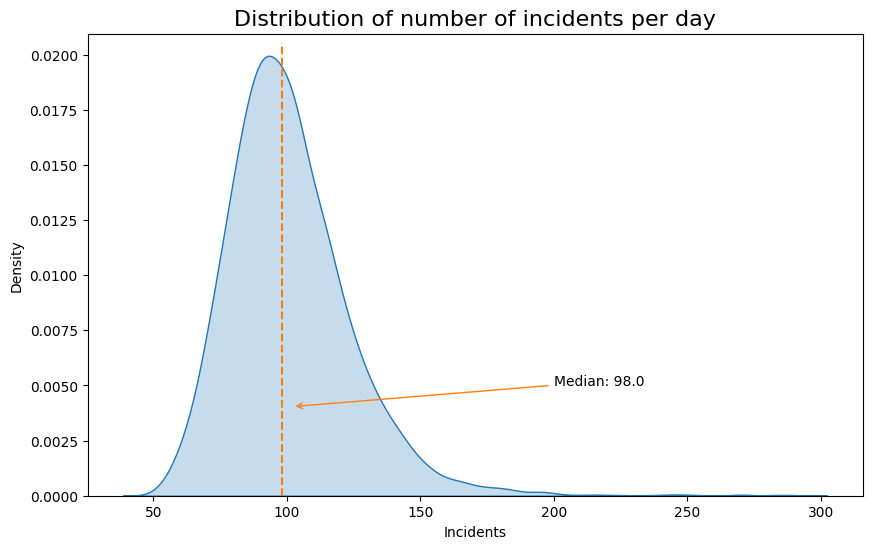

In [76]:
col = sns.color_palette()
plt.figure(figsize=(10, 6))
# Conta total de incidents por dia
data = dfmatrix.groupby('OCC_DATE').count().iloc[:, 0]
sns.kdeplot(data=data, shade=True)
plt.axvline(x=data.median(), ymax=0.98, linestyle='--', color=col[1])
plt.annotate(
    'Median: ' + str(data.median()),
    xy=(data.median(), 0.004),
    xytext=(200, 0.005),
    arrowprops=dict(arrowstyle='->', color=col[1], shrinkB=10))
plt.title(
    'Distribution of number of incidents per day', fontdict={'fontsize': 16})
plt.xlabel('Incidents')
plt.ylabel('Density')
plt.legend().remove()
plt.show()

## Análise de volume por dia de Semana

In [82]:
# SEPARA E CONTA O VOLUME POR DIA DA SEMANA
data = dfmatrix.groupby('OCC_DOW').count().iloc[:, 0]
data = data.reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday'
])


In [83]:
data

OCC_DOW
Monday       107
Tuesday       93
Wednesday     95
Thursday      79
Friday       118
Saturday     130
Sunday       130
Name: EVENT_UNIQUE_ID, dtype: int64

/var/folders/9r/ls5x2mk52kdb5744fdvsr7lh0000gn/T/ipykernel_35195/4004971072.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/var/folders/9r/ls5x2mk52kdb5744fdvsr7lh0000gn/T/ipykernel_35195/4004971072.py:8: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(


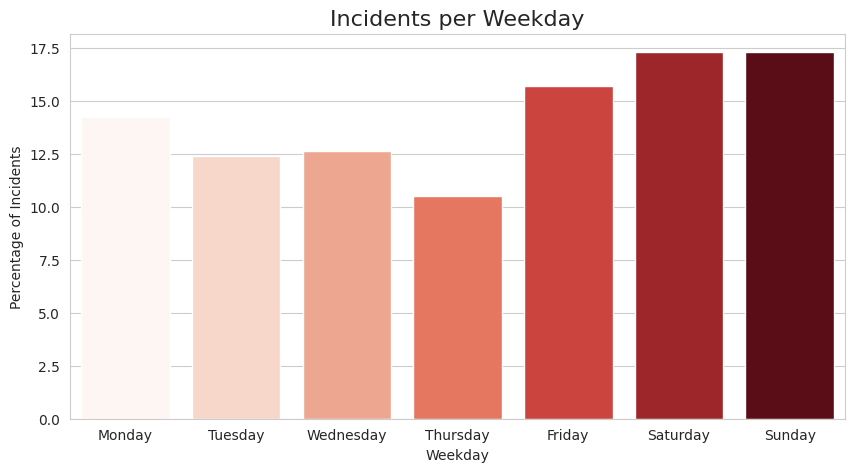

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

# Assuming 'data' is a pandas Series or DataFrame
plt.figure(figsize=(10, 5))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        x=data.index,
        y=(data.values / data.values.sum()) * 100,
        orient='v',
        palette=cm.Reds(np.linspace(0, 1, len(data)))
    )

plt.title('Incidents per Weekday', fontdict={'fontsize': 16})
plt.xlabel('Weekday')
plt.ylabel('Percentage of Incidents')
plt.show()

## Crimes per category analyse

In [114]:
df_sum_hour = dfmatrix['OCC_HOUR'].value_counts().reset_index(name='TOTAL')
print(df_sum_hour)

    OCC_HOUR  TOTAL
0          0  25568
1         21  20608
2         20  20534
3         18  20500
4         22  20387
5         12  20360
6         23  19780
7         19  19736
8         17  18983
9         15  18275
10        16  17583
11        14  15558
12         1  15494
13         2  15405
14        13  14464
15        11  13334
16         3  12821
17        10  12675
18         9  12453
19         8  10675
20         4  10313
21         5   7915
22         7   7838
23         6   6831


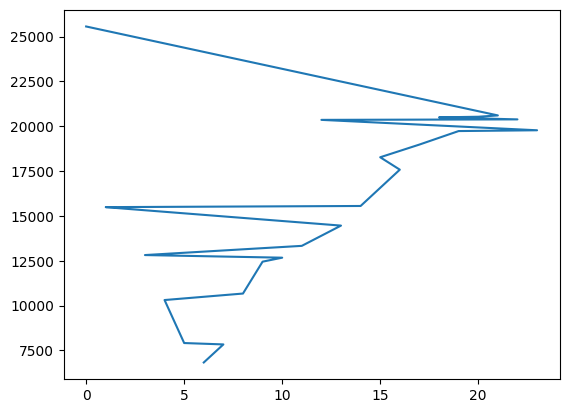

In [115]:
plt.plot(df_sum_hour['OCC_HOUR'], df_sum_hour['TOTAL'])

/var/folders/9r/ls5x2mk52kdb5744fdvsr7lh0000gn/T/ipykernel_35195/337281463.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


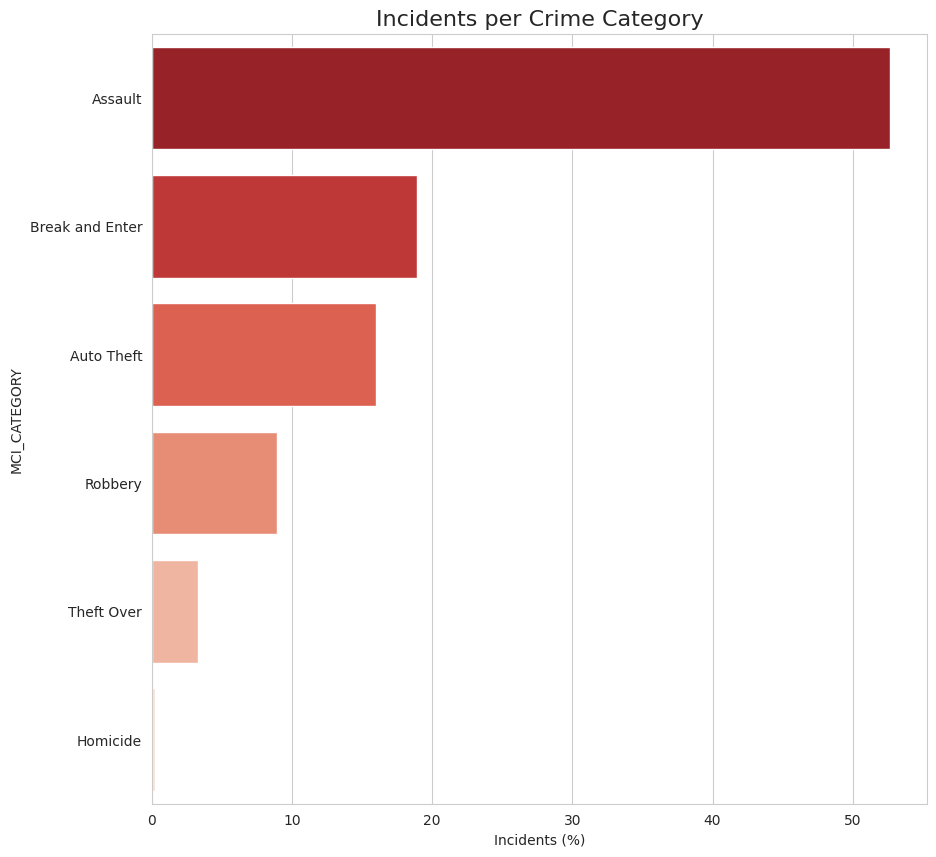

In [98]:
data = dfmatrix.groupby('MCI_CATEGORY').count().iloc[:, 0].sort_values(
    ascending=False)
#data = data.reindex(np.append(np.delete(data.index, 1), 'OTHER OFFENSES'))

plt.figure(figsize=(10, 10))
with sns.axes_style("whitegrid"):
    ax = sns.barplot(
        x=(data.values / data.values.sum()) * 100,
        y=data.index,
        orient='h',
        palette="Reds_r")
plt.title('Incidents per Crime Category', fontdict={'fontsize': 16})
plt.xlabel('Incidents (%)')

plt.show()

## Map

In [ ]:

ggplot(crime_data_2020_2022) + geom_bar(aes(occurrencehour))

In [118]:
import requests
import zipfile
import io
import geopandas as gpd
import folium
import os

# Step 1: Download the latest Toronto city map shapefile
url = 'https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/3e6b2878-c9a7-4f94-a6c9-137b41ee7c8d/resource/fe4d3c7d-6cce-4b14-9451-cb1b8a548345/download/Neighbourhoods.zip'
response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
zip_file.extractall('Toronto_Neighbourhoods')

# Step 2: Read the shapefile using GeoPandas
shapefile_path = 'Toronto_Neighbourhoods/Neighbourhoods.shp'
gdf = gpd.read_file(shapefile_path)

# Ensure the shapefile was read correctly
print(gdf.head())

# Step 3: Plot the map using Folium for interactive zooming
# Create a Folium map centered around Toronto
m = folium.Map(location=[43.651070, -79.347015], zoom_start=12)

# Add the shapefile data to the map
folium.GeoJson(gdf).add_to(m)

# Save the map to an HTML file
m.save('Toronto_Neighbourhoods_Map.html')

# Print a message to indicate that the map has been saved
print("Map has been saved to 'Toronto_Neighbourhoods_Map.html'")

# If you want to open the HTML file automatically in your default web browser
import webbrowser
webbrowser.open('Toronto_Neighbourhoods_Map.html')


BadZipFile: File is not a zip file